In [1]:
# import circuitsvis as cv
import numpy as np
import pandas as pd
import torch
# from sentence_transformers import SentenceTransformer
# from sklearn.decomposition import PCA
from taker import Model
from taker.hooks import HookConfig
import csv
import json
from datetime import datetime
from os import listdir
from os.path import exists
import einops

/workspace/SPAR/interp-ab/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# m = Model("google/gemma-2-2b-it", dtype="int8")
# m.show_details()

In [2]:
with open('../promptsV1.csv', newline='') as f:
    reader = csv.reader(f)
    readdata = list(reader)
    readdata = readdata[:20]


In [3]:
import sys, os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
max_new_tokens = 200
temperature = 0.3

In [5]:
orig_df = pd.read_json(f"../gemma9b_results/latest_orig_generation_new.jsonl", lines=True)
def split_at_double_newline(text):
    # Ensure we are only working with strings longer than 15 characters
    if len(text) > 15:
        # Search for the first double newline after the 15th character
        pos = text.find('\n\n', 15)
        if pos != -1:  # Check if double newline was found
            return text[:pos+2], text[pos:]  # Split and remove the newline from the second part
    return text, text  # If no split is required, return the original text and None

orig_df['paragraph1'], orig_df['paragraph2'] = zip(*orig_df['output'].apply(split_at_double_newline))
orig_df['paragraph1'] = orig_df['prompt'].astype(str) + orig_df['paragraph1'].astype(str)
print(repr(orig_df['paragraph1'][0]))

'Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.  \n\n'


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
m = AutoModelForCausalLM.from_pretrained(model_name)



In [7]:
m = m.to('cuda')
device = m.device
print(f"Model is currently on: {device}")


Model is currently on: cuda:0


In [8]:
def create_paragraph_attention_mask(input_ids, split_id, device="cuda"):
    # Ensure input_ids is 2D
    if len(input_ids.shape) == 1:
        input_ids = input_ids.unsqueeze(0)

    batch_size, seq_length = input_ids.shape

    # Create base causal mask (lower triangular)
    causal_mask = torch.ones((batch_size, 1, seq_length, seq_length), dtype=torch.bool, device=device)
    for i in range(seq_length):
        for j in range(i + 1, seq_length):
            causal_mask[:, :, i, j] = False

    # Find dot positions
    dot_indices = []

    for b in range(batch_size):
        for i in range(seq_length):
            if input_ids[b, i] == split_id:
                dot_indices.append(i)

    # Modify mask for paragraph attention control:
    # 1. Block attention between paragraphs
    # 2. Allow dots to see previous paragraphs
    # 3. Allow next paragraph to see the dot
    for dot_idx in dot_indices:
        # Block attention from tokens after dot to tokens before dot
        causal_mask[:, :, (dot_idx+1):, :dot_idx] = False

        # Allow dot to see all previous tokens
        causal_mask[:, :, dot_idx, :dot_idx] = True

        # Allow tokens after dot to see the dot
        causal_mask[:, :, (dot_idx+1):, dot_idx] = True

    # Convert to float and set -inf for masked positions
    attention_mask = causal_mask.float()
    attention_mask = attention_mask.masked_fill(~causal_mask, float("-inf"))

    return attention_mask



['<|begin_of_text|>', 'Tell', 'Ġme', 'Ġabout', 'Ġa', 'Ġweekend', 'Ġin', 'Ġa', 'Ġmountain', 'Ġcabin', 'Ġin', 'Ġ', '150', 'Ġwords', 'Ġand', 'Ġthen', 'Ġtell', 'Ġme', 'Ġabout', 'Ġdisconnect', 'ing', 'Ġfrom', 'Ġtechnology', 'Ġin', 'Ġanother', 'Ġ', '150', 'Ġwords', '.', 'ĠOnly', 'Ġdo', 'Ġthat', '.', 'ĠMake', 'Ġsure', 'Ġyou', 'Ġdon', 'âĢĻt', 'Ġadd', 'Ġany', 'Ġheadings', 'Ġor', 'Ġcomments', '.ĊĊ', 'The', 'Ġscent', 'Ġof', 'Ġpine', 'Ġneedles', 'Ġfilled', 'Ġthe', 'Ġair', 'Ġas', 'Ġwe', 'Ġdrove', 'Ġup', 'Ġthe', 'Ġwinding', 'Ġmountain', 'Ġroad', '.', 'Ġ', 'ĠOur', 'Ġcozy', 'Ġcabin', ',', 'Ġnestled', 'Ġamongst', 'Ġtowering', 'Ġtrees', ',', 'Ġwelcomed', 'Ġus', 'Ġwith', 'Ġwarmth', 'Ġand', 'Ġthe', 'Ġpromise', 'Ġof', 'Ġa', 'Ġpeaceful', 'Ġescape', '.', 'Ġ', 'ĠDays', 'Ġwere', 'Ġspent', 'Ġhiking', 'Ġthrough', 'Ġsun', '-d', 'app', 'led', 'Ġforests', ',', 'Ġthe', 'Ġsound', 'Ġof', 'Ġbirds', 'ong', 'Ġour', 'Ġonly', 'Ġsoundtrack', '.', 'ĠEven', 'ings', 'Ġwere', 'Ġspent', 'Ġby', 'Ġthe', 'Ġcrack', 'ling', 'Ġfirepla

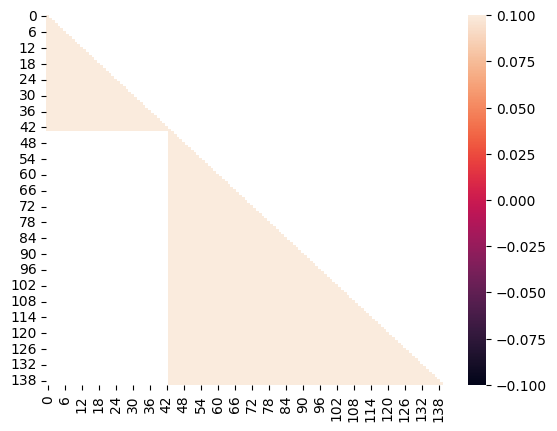

In [22]:
# idlist = m.get_ids(orig_df['paragraph1'][0]).squeeze().tolist()
# tokens = m.tokenizer.convert_ids_to_tokens(idlist)
# print(tokens)
def get_last_segment(text):
    segments = text.split('\n\n')
    return segments[-1].strip() if segments else ''

generated_outputs = []
for i, prompt in enumerate(orig_df['paragraph1'][:1]):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
    print(tokens)
    input_length = len(tokens)

    dot_id = tokenizer.encode(".\n\n")[-1]
    print(f"dot_id: {dot_id}, token: {tokenizer.convert_ids_to_tokens(dot_id)}")
    inputs['attention_mask'] = create_paragraph_attention_mask(inputs['input_ids'], dot_id, device=device)

    import seaborn as sns
    sns.heatmap(inputs['attention_mask'][0, 0].cpu().numpy())
    print(inputs['attention_mask'].shape)

    # repeat attention mask
    inputs['attention_mask'] = einops.repeat(inputs['attention_mask'], 'batch 1 i j-> batch head i j', head=32)
    inputs['attention_mask'] = inputs['attention_mask']

    inputs['position_ids'] = torch.arange(input_length).unsqueeze(0)
    print(inputs['attention_mask'].shape)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # outputs = m.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], position_ids = inputs['position_ids'],max_length=150, temperature=temperature,  do_sample=True)
    outputs = m(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], position_ids = inputs['position_ids'])

    print(outputs)
    print(outputs.keys())
    decoded_texts = []
    for position_logits in outputs['logits'].squeeze(0):  # Remove the batch dimension
    # Get the token index with the highest score at each position
        token_id = torch.argmax(position_logits).item()
        # Convert the token ID to the token string
        token = tokenizer.decode(token_id)
        decoded_texts.append(token)

    # Join all decoded tokens into a single string
    decoded_string = ' '.join(decoded_texts)

    print("Decoded text from logits:", decoded_string)
    # predicted_token_id = torch.argmax(outputs['logits'][:, -1, :], axis=-1)
    # predicted_text = tokenizer.decode(predicted_token_id)
    # print(predicted_text)
    # generated_text = tokenizer.decode(outputs['logits'], skip_special_tokens=True)
    # print(generated_text)
    # generated_outputs.append(get_last_segment(generated_text))

generated_df = pd.DataFrame({'generated_output': generated_outputs})
print(generated_df)



Still redoes the first paragraph

In [10]:
generated_df = pd.DataFrame({'generated_output': generated_outputs})
print(generated_df['generated_output'][0])

KeyError: 0

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# def get_last_segment(text):
#     segments = text.split('\n\n')
#     return '\n\n'.join(segments[2:]).strip() if len(segments) > 2 else ''
# print(generated_df['generated_output'][0])
# generated_df['generated_output'] = generated_df['generated_output'].apply(get_last_segment)
# print(generated_df['generated_output'][0])
with open("../gemma9b_results/latest_transferred_generation.jsonl", 'r') as file:
    transferred_outputs = [json.loads(line)['output'] for line in file][:20]
transferred_df = pd.DataFrame({'transferred_output': transferred_outputs})
combined_df = pd.concat([generated_df, transferred_df], axis=1)
model = SentenceTransformer('all-MiniLM-L6-v2')

generated_embeddings = model.encode(combined_df['generated_output'].tolist())
transferred_embeddings = model.encode(combined_df['transferred_output'].tolist())
similarities = cosine_similarity(generated_embeddings, transferred_embeddings)
combined_df['cosine_similarity'] = similarities.diagonal()

# print(combined_df)
# print("\nAverage Cosine Similarity:", combined_df['cosine_similarity'].mean())

In [ ]:

# Read original outputs
with open("../gemma9b_results/latest_orig_generation_new.jsonl", 'r') as file:
    original_outputs = []
    for i, line in enumerate(file):
        if i >= 20:
            break
        text = json.loads(line)['output']
        segments = text.split('\n\n')
        if len(segments) > 2:
            original_outputs.append('\n\n'.join(segments[2:]).strip())
        else:
            original_outputs.append('')

original_df = pd.DataFrame({'original_output': original_outputs})
combined_df = pd.concat([original_df, generated_df, transferred_df], axis=1)
original_embeddings = model.encode(combined_df['original_output'].tolist())

original_vs_transferred = cosine_similarity(original_embeddings, transferred_embeddings)
original_vs_generated = cosine_similarity(original_embeddings, generated_embeddings)

combined_df['original_vs_transferred_similarity'] = original_vs_transferred.diagonal()
combined_df['original_vs_generated_similarity'] = original_vs_generated.diagonal()

print(combined_df)
print("\nAverage Cosine Similarity (Original vs Transferred):", combined_df['original_vs_transferred_similarity'].mean())
print("Average Cosine Similarity (Original vs Generated):", combined_df['original_vs_generated_similarity'].mean())

                                      original_output generated_output  \
0   The world seemed to fade away as I stepped awa...                    
1   The silence was profound, broken only by the r...                    
2   The world fades away when you disconnect.  No ...                    
3   The world outside faded away as I switched off...                    
4   The silence was profound, broken only by the r...                    
5   The world fades away when you disconnect from ...                    
6   The silence was profound, broken only by the r...                    
7   The world outside faded away as I switched off...                    
8   The world outside faded away as I turned off m...                    
9   The silence was profound, broken only by the r...                    
10  The world seemed to shrink when I turned off m...                    
11  The silence was profound, broken only by the r...                    
12  The silence was profound, broken o

In [ ]:
# outputs = m.generate(**inputs, max_new_tokens=150, temperature=temperature, do_sample=True)
# generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
# # outputs = m.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=50, temperature=temperature)
# # generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
# # The error suggests that the model doesn't have a language model head for generation.

SyntaxError: invalid syntax (1378058850.py, line 15)

In [ ]:
# neutral_prompts = ["\n\n"]
# # Apply the function to the DataFrame column
# filename = f"../gemma9b_results/latest_transferred_generation.jsonl"
# if not exists(filename):
#     with open(filename, "w") as f:
#         pass

# for info_prompt in orig_df['paragraph1']:
#     acts = m.get_midlayer_activations(info_prompt)
#     orig_token_index = m.get_ids(info_prompt).shape[1] - 1
#     for neutral_prompt in neutral_prompts:
#         new_token_index  = m.get_ids(neutral_prompt).shape[1] - 1

#         [h.reset() for h in m.hooks.neuron_replace.values()] #RESET HOOKS BEFORE TRANSPLANTING NEXT SET OF ACTIVATIONS
#         for layer_index in range(0,42):
#             m.hooks.neuron_replace[f"layer_{layer_index}_mlp_pre_out"].add_token(new_token_index, acts["mlp"][0, layer_index, orig_token_index])
#             m.hooks.neuron_replace[f"layer_{layer_index}_attn_pre_out"].add_token(new_token_index, acts["attn"][0, layer_index, orig_token_index])
#         with HiddenPrints():
#             # for i in range(1):
#                 output = m.generate(neutral_prompt, max_new_tokens, temperature=temperature)

#                 data = {
#                     "temperature": temperature,
#                     "max_new_tokens": max_new_tokens,
#                     "model": "google/gemma-2-9b-it",
#                     "type": "transferred",
#                     "num_transferred_tokens": 1,
#                     "transplant_layers": (0,42),
#                     "orig_prompt": info_prompt,
#                     "transplant_prompt": neutral_prompt,
#                     "output": output[1],
#                 }

#                 with open(filename, "a") as file:
#                     file.write(json.dumps(data) + "\n")

In [ ]:
for info_prompt in orig_df['paragraph1']:
    acts = m.get_midlayer_activations(info_prompt)

